# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1,2</sup>, Rafael Martinez-Galarza<sup>1</sup>, Alexander Caicedo-Dorado<sup>3</sup>, Raffaele D'Abrusco<sup>1</sup>*

*1. Center for Astrophysics | Harvard & Smithsonian, 2. Universidad del Rosario, 3. Pontificia Universidad Javeriana*

Contact ```vperezdiaz@cfa.harvard.edu``` for questions or comments.


#### Classification exploration

---

In [1]:
%load_ext autoreload
%autoreload 2

from umlcaxs_lib import votable_to_pandas, lognorm, mahalanobis, mahal_classifier_cl, create_summary_tables, process_data_for_validation, mahal_classifier_validation
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.stats import inter_rater as irr

from collections import Counter

from urllib.parse import urlencode
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astroquery.hips2fits import hips2fits
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import astropy.units as u
from astropy.coordinates import Longitude, Latitude, Angle
import aplpy

from scipy.stats import gaussian_kde

%matplotlib inline

In [2]:
# Edit the font, font size, and axes width

mpl.rcParams['font.family'] = 'Avenir LT Std'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

In [3]:
df_classified_cscs = pd.read_csv('./out_data/classified_cscs.csv', index_col=0)
df_class_agreeing = pd.read_csv('./out_data/agreeing_classification.csv', index_col=0)
df_classified_cscs.set_index('name', inplace=True)
df_class_confused = pd.read_csv('./out_data/confused_classification.csv', index_col=0)
df_cluster_csc_simbad = pd.read_csv('./out_data/cluster_csc_simbad.csv', index_col=0)
ltypes = ['QSO', 'AGN', 'Seyfert_1', 'Seyfert_2', 'HMXB', 'LMXB', 'XB', 'YSO', 'TTau*', 'Orion_V*']
grouped_types = ['AGN', 'Seyfert', 'XB', 'YSO']
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
df_class_cscs_grouped = df_classified_cscs.main_type.replace(grouped_replace)

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (56,63,64,65,66,67,68,73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
nans_df_csc_simbad = df_cluster_csc_simbad.copy(deep=True).fillna({'main_type': 'NaN'})

In [ ]:
# Features that we use in our analysis
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

# Features to log transform and normalize
features_lognorm = ['bb_kt', 'var_ratio_h', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

# Features to normalize
features_norm = ['powlaw_gamma']

# Drop data with missing values in features
df_cscs_out = nans_df_csc_simbad.dropna(subset=features)

In [ ]:
uks = ['Star', 'X', 'Radio', 'IR', 'Blue', 'UV', 'gamma', 'PartofG', '**']

df_cscs_out_clean = process_data_for_validation(df_cscs_out, ltypes, uks=uks)

In [ ]:
uks = ['Star', 'X', 'Radio', 'IR', 'Blue', 'UV', 'gamma', 'PartofG', '**']
nans_df_csc_simbad = df_cluster_csc_simbad.copy(deep=True).fillna({'main_type': 'NaN'})
create_summary_tables(nans_df_csc_simbad[nans_df_csc_simbad.cluster==5]).head(10).to_latex('latex_file.txt')

In [ ]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 5, figsize=(26,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("hard_hm")
coly = df_classified_cscs.columns.get_loc("hard_hs")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{ltypes[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_classified_cscs.main_type==ltypes[i]], x='hard_hm', y='hard_hs', cmap='inferno', fill=True, alpha=1, ax=ax)
    
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

plt.savefig('./figures/results_class_exp_hard.pdf', bbox_inches='tight')  

In [ ]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 5, figsize=(26,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("var_prob_s")
coly = df_classified_cscs.columns.get_loc("var_prob_b")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{ltypes[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_classified_cscs.main_type==ltypes[i]], x='var_prob_s', y='var_prob_b', cmap='inferno', fill=True, alpha=1, ax=ax)
    
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])

plt.savefig('./figures/results_class_exp_var.pdf', bbox_inches='tight')  

In [ ]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 2, figsize=(16,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("hard_hm")
coly = df_classified_cscs.columns.get_loc("hard_hs")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{grouped_types[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_class_cscs_grouped==grouped_types[i]], x='hard_hm', y='hard_hs', cmap='inferno', fill=True, alpha=1, ax=ax)
    
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

plt.savefig('./figures/results_class_exp_hard_grouped.pdf', bbox_inches='tight')  

In [ ]:
plt.style.use("dark_background")
fig, axs = plt.subplots(2, 2, figsize=(16,10), tight_layout=True)

colx = df_classified_cscs.columns.get_loc("var_prob_s")
coly = df_classified_cscs.columns.get_loc("var_prob_b")

for i, ax in enumerate(fig.axes):
    sns.set(style="ticks", context="talk")
    ax.set_title(f'{grouped_types[i]}', size=16)
    
    #ax.grid(True)
    ax.set_xlabel(df_classified_cscs.columns[colx])
    ax.set_ylabel(df_classified_cscs.columns[coly])
    g=sns.kdeplot(data=df_classified_cscs[df_class_cscs_grouped==grouped_types[i]], x='var_prob_s', y='var_prob_b', cmap='inferno', fill=True, alpha=1, bw_adjust=.1, ax=ax)
    #g=sns.scatterplot(data=df_classified_cscs[df_class_cscs_grouped==grouped_types[i]], x='var_prob_s', y='var_prob_b', s=10, ax=ax)
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])

plt.savefig('./figures/results_class_exp_var_grouped.pdf', bbox_inches='tight')  

#### Position in sky
---

In [ ]:
query_results = Simbad.query_region('M42')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

In [ ]:
colors = sns.color_palette("bright", 4)

In [ ]:
hips_allwise = 'CDS/P/allWISE/W1'
result1 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords[0].ra,
   dec=object_coords[0].dec,
   fov=Angle(4 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [ ]:
# M42
yso_names = df_class_confident[df_class_confident.agg_master_class=='YSO'].index
agn_names = df_class_confident[df_class_confident.agg_master_class=='AGN'].index
xb_names = df_class_confident[df_class_confident.agg_master_class=='XB'].index
sey_names = df_class_confident[df_class_confident.agg_master_class=='Seyfert'].index


df_yso = df_classified_cscs.loc[yso_names].drop_duplicates()
df_agn = df_classified_cscs.loc[agn_names].drop_duplicates()
df_xb = df_classified_cscs.loc[xb_names].drop_duplicates()
df_sey = df_classified_cscs.loc[sey_names].drop_duplicates()
gc = aplpy.FITSFigure(result1) 
gc.show_grayscale() 

gc.show_markers(df_agn.ra, df_agn.dec, layer='marker_set_1',
                facecolor=np.array(colors[0]), edgecolor='white', marker='^', s=40, alpha=0.5, label='AGN')

gc.show_markers(df_sey.ra, df_sey.dec, layer='marker_set_2',
                facecolor=np.array(colors[1]),edgecolor='white', marker='X', s=40, alpha=0.5, label='Seyfert')

gc.show_markers(df_xb.ra, df_xb.dec, layer='marker_set_3',
                facecolor=np.array(colors[2]), edgecolor='white', marker='s', s=40, alpha=0.5, label='XB')

gc.show_markers(df_yso.ra, df_yso.dec, layer='marker_set_4',
               facecolor=np.array(colors[3]), edgecolor='white', marker='o', s=40, alpha=0.5, label='YSO')
gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

plt.savefig('./figures/m42.pdf', bbox_inches='tight')  

In [ ]:
# COSMOS
query_results = Simbad.query_region('Cosmos Field')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords_cosmos = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

result2 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords_cosmos[0].ra,
   dec=object_coords_cosmos[0].dec,
   fov=Angle(30 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [ ]:
gc = aplpy.FITSFigure(result2) 
gc.show_grayscale() 

gc.show_markers(df_agn.ra, df_agn.dec, layer='marker_set_1',
                facecolor=np.array(colors[0]), edgecolor='white', marker='^', s=40, alpha=0.5, label='AGN')

gc.show_markers(df_sey.ra, df_sey.dec, layer='marker_set_2',
                facecolor=np.array(colors[1]),edgecolor='white', marker='X', s=40, alpha=0.5, label='Seyfert')

gc.show_markers(df_xb.ra, df_xb.dec, layer='marker_set_3',
                facecolor=np.array(colors[2]), edgecolor='white', marker='s', s=40, alpha=0.5, label='XB')

gc.show_markers(df_yso.ra, df_yso.dec, layer='marker_set_4',
               facecolor=np.array(colors[3]), edgecolor='white', marker='o', s=40, alpha=0.5, label='YSO')
gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

plt.savefig('./figures/cosmos.pdf', bbox_inches='tight')  

In [ ]:
# M33
query_results = Simbad.query_region('M33')                                                      
object_main_id = query_results[0]['MAIN_ID']
object_coords_m33 = SkyCoord(ra=query_results['RA'], dec=query_results['DEC'], 
                         unit=(u.hourangle, u.deg), frame='icrs')

result3 = hips2fits.query(
   hips=hips_allwise,
   width=1000,
   height=500,
   ra=object_coords_m33[0].ra,
   dec=object_coords_m33[0].dec,
   fov=Angle(2 * u.deg),
   projection="AIT",
   get_query_payload=False,
   format='fits',
   min_cut=0.5,
   max_cut=99.5,
   cmap=Colormap('viridis'),
)

In [ ]:
gc = aplpy.FITSFigure(result3) 
gc.show_grayscale() 

gc.show_markers(df_agn.ra, df_agn.dec, layer='marker_set_1',
                facecolor=np.array(colors[0]), edgecolor='white', marker='^', s=40, alpha=0.5, label='AGN')

gc.show_markers(df_sey.ra, df_sey.dec, layer='marker_set_2',
                facecolor=np.array(colors[1]),edgecolor='white', marker='X', s=40, alpha=0.5, label='Seyfert')

gc.show_markers(df_xb.ra, df_xb.dec, layer='marker_set_3',
                facecolor=np.array(colors[2]), edgecolor='white', marker='s', s=40, alpha=0.5, label='XB')

gc.show_markers(df_yso.ra, df_yso.dec, layer='marker_set_4',
               facecolor=np.array(colors[3]), edgecolor='white', marker='o', s=40, alpha=0.5, label='YSO')
gc.axis_labels.set_xtext('RA')
gc.axis_labels.set_ytext('Dec')
plt.legend(facecolor='k', labelcolor='w')

plt.savefig('./figures/m33.pdf', bbox_inches='tight')  

#### Probabilities

---

In [4]:
def plot_source_probability(df, df_c, source_name, ltypes):
    target_df_melted = pd.melt(df[ltypes], value_vars=ltypes, ignore_index=False)
    target_df = target_df_melted[target_df_melted.index == source_name]
    confident_class = df_c[df_c.index == source_name].master_class[0]
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
    
    ax1.yaxis.set_tick_params(which='major', size=6, width=0.5, direction='in')
    ax1.yaxis.set_tick_params(which='minor', size=3, width=0.5, direction='in')
    ax1.xaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
    ax1.xaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
    ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.125))
    sns.lineplot(data=target_df, x='variable', y='value', color='black', markers=True, marker='o', ax=ax1)
    ax1.scatter(x=confident_class, y=target_df[target_df.variable == confident_class].mean(), marker='s', c='r', edgecolors='black', s=100, zorder=3)
    ax1.set_xticks(ltypes)
    ax1.set_xticklabels(ltypes, rotation=90)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Probability')
    ax1.set_ylim([-0.05,1.05])
    ax1.set_title(source_name+', '+str(confident_class), fontsize=12)


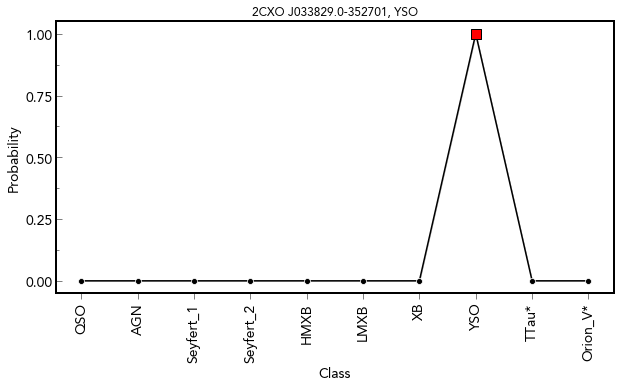

In [5]:
sname = '2CXO J033829.0-352701'
plot_source_probability(df_classified_cscs, df_class_agreeing, sname, ltypes)
#plt.savefig('figures/{}.pdf'.format(sname), dpi=300, transparent=False, bbox_inches='tight')

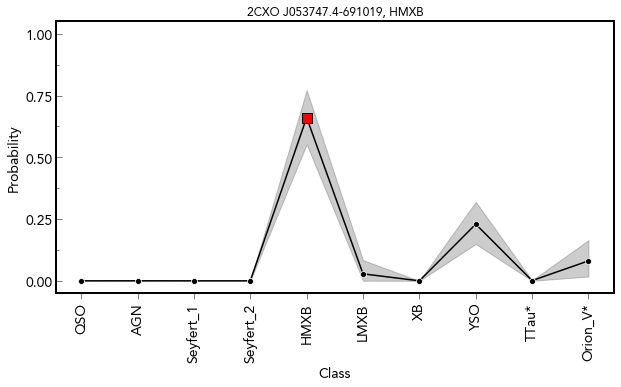

In [7]:
sname = '2CXO J053747.4-691019'
plot_source_probability(df_classified_cscs, df_class_agreeing, sname, ltypes)
#plt.savefig('figures/{}.pdf'.format(sname), dpi=300, transparent=False, bbox_inches='tight')

In [22]:
df_class_agreeing[df_class_agreeing.index == '2CXO J033829.0-352701']

,agg_master_class,master_class,detection_count,QSO,AGN,Seyfert_1,Seyfert_2,HMXB,LMXB,XB,YSO,TTau*,Orion_V*
name,,,,,,,,,,,,,
2CXO J033829.0-352701,YSO,YSO,6,0.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,1.0±0.0,0.0±0.0,0.0±0.0


In [18]:
df_class_confused

,hard_master_class,soft_master_class,detection_count,QSO,AGN,Seyfert_1,Seyfert_2,HMXB,LMXB,XB,YSO,TTau*,Orion_V*
name,,,,,,,,,,,,,
2CXO J004228.2+411222,LMXB,HMXB,66,0.057±0.136,0.113±0.181,0.128±0.234,0.095±0.217,0.217±0.238,0.171±0.211,0.167±0.25,0.006±0.017,0.004±0.018,0.043±0.17
2CXO J004246.9+411615,Seyfert_1,LMXB,22,0.074±0.143,0.063±0.088,0.219±0.258,0.118±0.2,0.125±0.148,0.226±0.236,0.115±0.181,0.005±0.013,0.003±0.013,0.051±0.203
2CXO J004244.3+411608A,Seyfert_1,QSO,15,0.24±0.297,0.09±0.126,0.162±0.203,0.092±0.25,0.06±0.125,0.027±0.056,0.012±0.03,0.155±0.284,0.014±0.041,0.147±0.277
2CXO J004244.3+411608,Seyfert_1,QSO,15,0.24±0.297,0.09±0.126,0.162±0.203,0.092±0.25,0.06±0.125,0.027±0.056,0.012±0.03,0.155±0.284,0.014±0.041,0.147±0.277
2CXO J010043.0-721133,Orion_V*,YSO,14,0.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,0.009±0.022,0.121±0.29,0.0±0.0,0.423±0.408,0.035±0.101,0.412±0.379
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J013449.0+303328,LMXB,HMXB,2,0.011±0.006,0.069±0.016,0.155±0.051,0.034±0.011,0.25±0.134,0.212±0.128,0.112±0.105,0.01±0.005,0.146±0.146,0.001±0.001
2CXO J192534.9+500725,TTau*,QSO,2,0.407±0.406,0.088±0.075,0.086±0.086,0.001±0.0,0.063±0.063,0.031±0.031,0.008±0.008,0.0±0.0,0.302±0.302,0.013±0.013
2CXO J213619.9-543146,XB,HMXB,2,0.113±0.063,0.086±0.084,0.012±0.012,0.07±0.07,0.573±0.373,0.006±0.006,0.139±0.139,0.001±0.001,0.0±0.0,0.0±0.0


In [21]:
grouped_replace_c = {'AGN':'AGN+Seyfert','QSO': 'AGN+Seyfert', 'Seyfert_1': 'AGN+Seyfert', 'Seyfert_2': 'AGN+Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO'}

sum(df_class_confused.hard_master_class.replace(grouped_replace_c) == df_class_confused.soft_master_class.replace(grouped_replace_c))

222

In [ ]:
plt.style.use("dark_background")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), tight_layout=True)

source_props = df_classified_cscs[df_classified_cscs.index == sname]
xname = 'hard_hm'
yname = 'hard_hs'
classname = 'YSO'#df_class_confident[df_class_confident.index==sname].master_class[0]
sns.set(style="ticks", context="talk")
sns.kdeplot(data=df_cscs_out_clean[df_cscs_out_clean.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1, ax=ax1)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax1)

sns.kdeplot(data=df_classified_cscs[df_classified_cscs.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1, ax=ax2)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax2, label=f'{sname}')

ax1.set_xlim([-1.1,1.1])
ax1.set_ylim([-1.1,1.1])
ax2.set_xlim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])

ax1.set_title('"Training" sources')
ax2.set_title('Confident classified sources')
plt.legend()

fig.suptitle(f'{classname}', color='white')

#plt.savefig(f'figures/{sname}_dist_powbb_{classname}.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
from itertools import combinations

classname = 'YSO'#df_class_confident[df_class_confident.index==sname].master_class[0]
df_cscs_out_clean_lognorm = lognorm(df_cscs_out_clean, features, features_norm, features_lognorm)
df_classified_cscs_lognorm = lognorm(df_classified_cscs, features, features_norm, features_lognorm)
source_props = df_classified_cscs_lognorm[df_classified_cscs_lognorm.name == sname]

for feats in combinations(features, 2):
    plt.style.use("dark_background")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), tight_layout=True)
    xname = feats[0]
    yname = feats[1]
    sns.set(style="ticks", context="talk")
    sns.kdeplot(data=df_cscs_out_clean_lognorm[df_cscs_out_clean_lognorm.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1,  bw_adjust=.4, ax=ax1)
    sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax1)

    sns.kdeplot(data=df_classified_cscs_lognorm[df_classified_cscs_lognorm.main_type==classname], x=xname, y=yname, cmap='inferno', fill=True, alpha=1,  bw_adjust=.4, ax=ax2)
    sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax2, label=f'{sname}')

    #ax1.set_xlim([-1.1,1.1])
    #ax1.set_ylim([-1.1,1.1])
    #ax2.set_xlim([-1.1,1.1])
    #ax2.set_ylim([-1.1,1.1])

    ax1.set_title('"Training" sources')
    ax2.set_title('Agreeing classified sources')
    plt.legend()

    fig.suptitle(f'{classname}', color='white')

    plt.savefig(f'figures_supp/{sname}_dist_{xname}_{yname}_{classname}.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
plt.style.use("dark_background")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), tight_layout=True)

source_props = df_classified_cscs[df_classified_cscs.index == sname]
xname = 'hard_hm'
yname = 'hard_hs'
classname = 'YSO'#df_class_confident[df_class_confident.index==sname].master_class[0]
sns.set(style="ticks", context="talk")
sns.scatterplot(data=df_cscs_out_clean[df_cscs_out_clean.main_type==classname], x=xname, y=yname, s=20, ax=ax1)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax1)

sns.scatterplot(data=df_classified_cscs[df_classified_cscs.main_type==classname], x=xname, y=yname, s=20, ax=ax2)
sns.scatterplot(data=source_props, x=xname, y=yname, color='white', edgecolor='black', ax=ax2, label=f'{sname}')

#### Sky

In [ ]:
df_class_confident_with_coords = df_class_confident.merge(df_classified_cscs[['ra', 'dec', 'hard_hs', 'hard_hm']].drop_duplicates(), on='name', how='left')
xarr = df_class_confident_with_coords.ra
yarr = df_class_confident_with_coords.dec
eq = SkyCoord(xarr[:], yarr[:], unit=u.deg)
gal = eq.galactic

df_class_confident_with_coords['l'] = gal.l.wrap_at('180d').radian
df_class_confident_with_coords['b'] = gal.b.radian

In [ ]:
df_class_confident_with_coords.l

In [ ]:
df_class_confident_with_coords_to_plot.l.max()

In [ ]:
df_class_confident_with_coords_to_plot = df_class_confident_with_coords[(df_class_confident_with_coords['hard_hm'] <= -0.5) & (df_class_confident_with_coords['hard_hs'] <= -0.5)]
df_class_confident_with_coords_to_plot = df_class_confident_with_coords_to_plot[df_class_confident_with_coords_to_plot.agg_master_class == 'YSO']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='mollweide')
ax.grid(True)

scatter = sns.scatterplot(data=df_class_confident_with_coords_to_plot, x='l', y='b', hue='hard_hs', palette="inferno", alpha=0.6, s=60, rasterized=True)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='hard_hs')
ax.annotate('Fornax Cluster', xy=[4.13, 0.93])
plt.savefig('./figures/results_hards_m0.5.pdf', bbox_inches='tight')  

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='mollweide')
ax.grid(True)

scatter = sns.scatterplot(data=df_class_confident_with_coords, x='l', y='b', hue='agg_master_class', palette="bright", hue_order=grouped_types, alpha=0.6, s=20, rasterized=True)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='Aggregated Class')

plt.savefig('./figures/results_galactic_classes.pdf', bbox_inches='tight')  

In [ ]:
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection='mollweide'), figsize=(20,10), tight_layout=True)

for i, ax in enumerate(fig.axes):
    ax.set_title(grouped_types[i], size=16)
    
    df_coords_cl = df_class_confident_with_coords[df_class_confident_with_coords.agg_master_class == grouped_types[i]]

    x=df_coords_cl.l
    y=df_coords_cl.b

    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    cf = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1, shading='auto', cmap='inferno', edgecolors='none', rasterized=True)

plt.savefig('./figures/results_galactic_classes_dens.pdf', bbox_inches='tight')  

#### To LaTeX
---

In [ ]:
def bold_class_prob(row):
    to_format = row[row['master_class']]
    row[row.master_class] = "\\textbf{%s}" % to_format
    return row

In [ ]:
df_cc_to_latex = df_class_confident.apply(lambda x: bold_class_prob(x), axis=1)

In [ ]:
df_cc_to_latex.head(10).to_latex('latex_file.txt')

In [ ]:
df_class_confused.head(10).to_latex('latex_file.txt')

In [ ]:
data_cluster = pd.read_csv('./out_data/cluster_csc_simbad.csv')

In [ ]:
data_cluster.shape